# Validação do modelo linear das taxas para a variação angula p(t)

Validamos o modelo linear encontrado no script `identificação_de_sistemas.ipynb`.

1. Carregar os dados utilizados para avalidação.
2. Carregar os parâmetros calibrados dos modelos.
3. Comparar o modelo com os dados coletados.

In [13]:
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')  # Configurar o backend para TkAgg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid, quad
import scipy.optimize as optimize
from myfunctions import *
from numpy.random import uniform
import pickle


# Modelo da dinâmica da taxa p
$$
\dfrac{P(s)}{U(s)}=ke^{-\tau s}\left(\dfrac{Ts+1}{\alpha T s+1}\right)\left(\dfrac{1}{I_{xx}s}\right).
$$
Os valores utilizados a seguir foram obtidos por tentaiva e erro a partir da observação da resposta em frequência.
O protótipo do modelo linear identificado para $P(s)$ é:
$$
\dfrac{P(s)}{U(s)}=Ke^{-\tau s}\left(\dfrac{s+a}{s+b}\right)\left(\dfrac{1}{s}\right).
$$
com $K$, $\tau$, $a$ e $b$ como parâmetros livres para otimização. A relação dos parâmetros do prtótipo com o modelo original é a seguinte 

$$T=1/a,$$ 
$$\alpha=a/b,$$ 
$$aK/b=k/I_{xx}.$$


---
1. Carregar os dados utilizados para avalidação.

In [3]:
# Para esse test utilizamos o seguinte conjunto de dados
file_path = 'ulogs/log_1_2024-9-3-07-56-31.ulg' # double sawtooth signal 0k! Tem poucos harmônicos
# Ler o arquivo .ulg
ulog = read_ulog(file_path)

In [4]:
# Coletar os dados dos atuadores
timestamps_c0, control0 = get_ulog_data(ulog, 'actuator_motors', 'control[0]')
timestamps_c1, control1 = get_ulog_data(ulog, 'actuator_motors', 'control[1]')
timestamps_c2, control2 = get_ulog_data(ulog, 'actuator_motors', 'control[2]')
timestamps_c3, control3 = get_ulog_data(ulog, 'actuator_motors', 'control[3]')

# Coletar os dados das taxas de rotação
timestamps_vav0, vav0 = get_ulog_data(ulog, 'vehicle_angular_velocity', 'xyz[0]')

In [5]:
dt_controle = timestamps_c0[1] - timestamps_c0[0]  # Período de amostragem dos dados
t_controle = np.linspace(0, len(control0)*dt_controle, len(control0))  # Vetor de tempo
#
dt_taxas = timestamps_vav0[1] - timestamps_vav0[0]  # Período de amostragem dos dados
t_taxas = np.linspace(0, len(vav0)*dt_taxas, len(vav0))  # Vetor de tempo

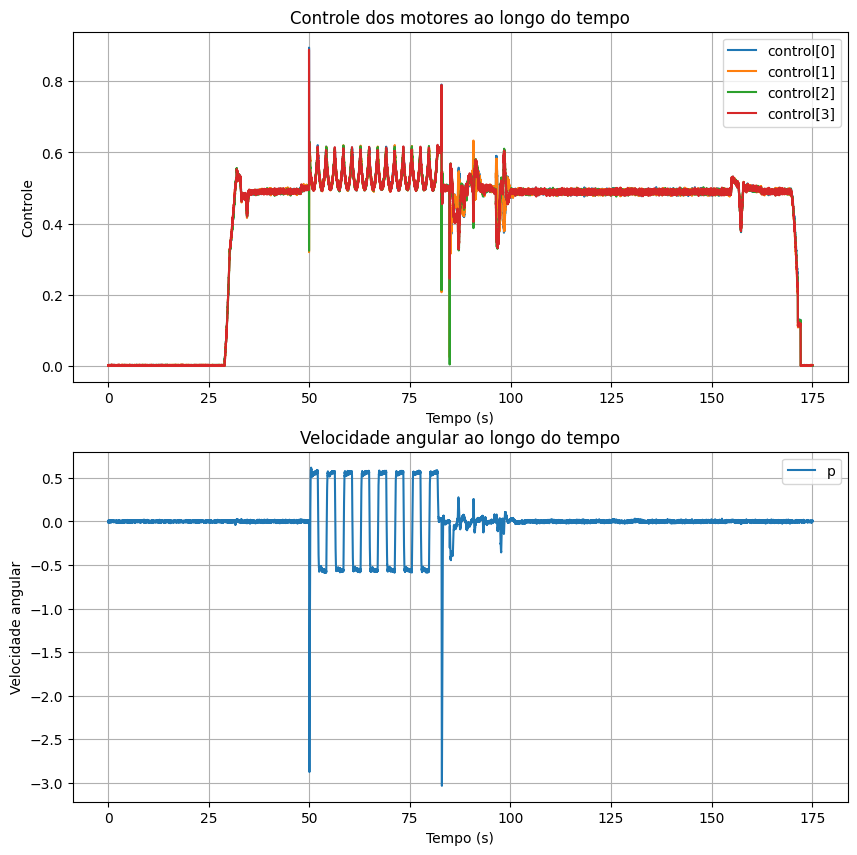

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
#
ax1.plot(t_controle, control0, label='control[0]')
ax1.plot(t_controle, control1, label='control[1]')
ax1.plot(t_controle, control2, label='control[2]')
ax1.plot(t_controle, control3, label='control[3]')
#
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Controle dos motores ao longo do tempo')
ax1.legend()
ax1.grid()
#
ax2.plot(t_taxas, vav0, label='p')
#
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade angular')
ax2.set_title('Velocidade angular ao longo do tempo')
ax2.legend()
ax2.grid()
#
#plt.tight_layout()
plt.show()
#  

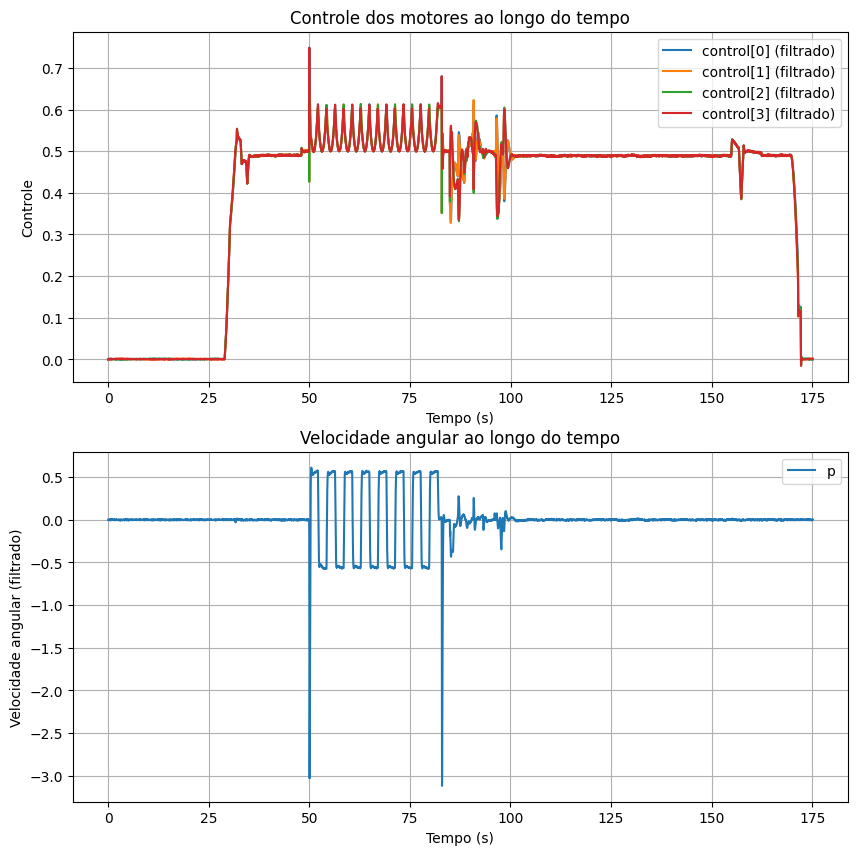

In [7]:
# filtrar o sinal de controle
fc = 10  # Frequência de corte
control0_filtrado = butter_lowpass_filter(control0, fc, 1/dt_controle)
control1_filtrado = butter_lowpass_filter(control1, fc, 1/dt_controle)
control2_filtrado = butter_lowpass_filter(control2, fc, 1/dt_controle)
control3_filtrado = butter_lowpass_filter(control3, fc, 1/dt_controle)
#
# filtrar as derivadas dos controles
#dcontrol0_filtrado = butter_lowpass_filter(dcontrole0, fc, 1/dt_controle)
#dcontrol1_filtrado = butter_lowpass_filter(dcontrole1, fc, 1/dt_controle)
#dcontrol2_filtrado = butter_lowpass_filter(dcontrole2, fc, 1/dt_controle)
#dcontrol3_filtrado = butter_lowpass_filter(dcontrole3, fc, 1/dt_controle)
#
# filtrar o sinal de velocidade angular
vav0_filtrado = butter_lowpass_filter(vav0, fc, 1/dt_taxas)
# Plotar os sinais filtrados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
#
ax1.plot(t_controle, control0_filtrado, label='control[0] (filtrado)')
ax1.plot(t_controle, control1_filtrado, label='control[1] (filtrado)')
ax1.plot(t_controle, control2_filtrado, label='control[2] (filtrado)')
ax1.plot(t_controle, control3_filtrado, label='control[3] (filtrado)')
#
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Controle dos motores ao longo do tempo')
ax1.legend()
ax1.grid()
#
ax2.plot(t_taxas, vav0_filtrado, label='p')
#
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade angular (filtrado)')
ax2.set_title('Velocidade angular ao longo do tempo')
ax2.legend()
ax2.grid()
#
#plt.tight_layout()
plt.show()


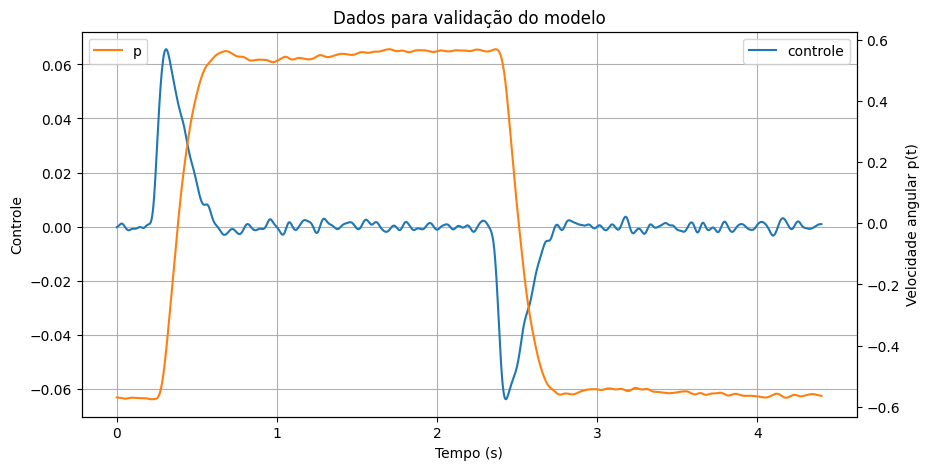

In [8]:
# Recortando os dados para análise
t0 = 54.0
t1 = 58.4 #80.0
idx0 = int(t0/dt_controle)
idx1 = int(t1/dt_controle)
control0_rec = control0_filtrado[idx0:idx1]
control1_rec = control1_filtrado[idx0:idx1]
control2_rec = control2_filtrado[idx0:idx1]
control3_rec = control3_filtrado[idx0:idx1]
t_controle_rec = t_controle[idx0:idx1]

# Essa operação também remove a média dos sinais de controle. Cuidado.
controle = control1_rec + control2_rec - control0_rec - control3_rec

#
idx0 = int(t0/dt_taxas)
idx1 = int(t1/dt_taxas)
taxa_p = vav0_filtrado[idx0:idx1]
t_taxas_rec = t_taxas[idx0:idx1]
#
# tempo de amostragem
dt = t_controle_rec[1] - t_controle_rec[0]
tempo = np.linspace(0, len(controle)*dt, len(controle))
#
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(tempo, controle, label='controle', color='tab:blue')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Dados para validação do modelo')
ax1.legend(loc='upper right')
ax1.grid()
#
ax2 = ax1.twinx()
ax2.plot(tempo, taxa_p, label='p', color='tab:orange')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade angular p(t)')
ax2.legend(loc='upper left')
#ax2.grid()
#
#plt.tight_layout()
plt.show()

In [9]:
# calcula a derivada do sinal de controle
dt = tempo[1] - tempo[0]
dcontrole = np.gradient(controle, dt)
# filtrar a derivada do sinal de controle
fc = 100 # (Hz) frequência de corte da derivada do sinal de controle.
dcontrole_filt = butter_lowpass_filter(dcontrole, fc, 1/dt)

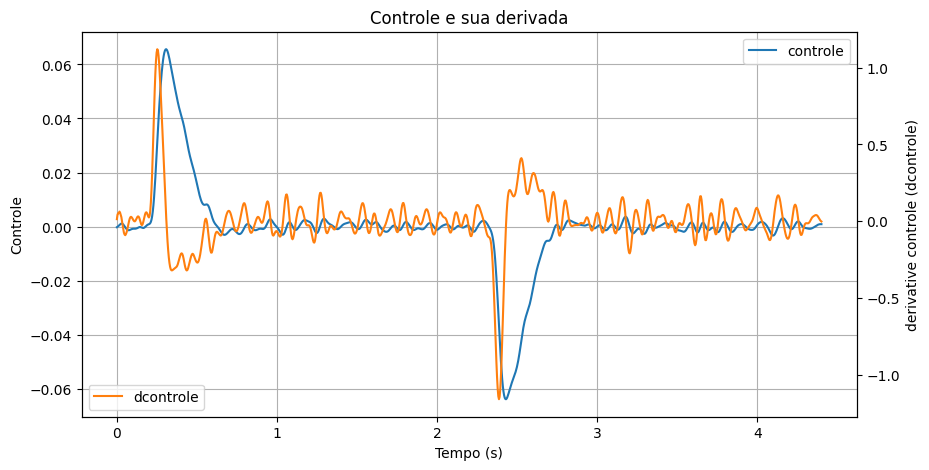

In [10]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(tempo, controle, label='controle', color='tab:blue')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Controle e sua derivada')
ax1.legend(loc='upper right')
ax1.grid()
#
ax2 = ax1.twinx()
ax2.plot(tempo, dcontrole_filt, label='dcontrole', color='tab:orange')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('derivative controle (dcontrole)')
ax2.legend(loc='lower left')
plt.show()

In [17]:
# carregar os parâmetros do arquivo parametros.pkl 
with open('p_rate_parametros.pkl', 'rb') as f:
    parametros = pickle.load(f)

# Acessar os parâmetros individuais
tau = parametros['tau']
K = parametros['K']
a = parametros['a']
b = parametros['b']

# Exibir os parâmetros carregados
print(f"tau: {tau}")
print(f"K: {K}")
print(f"a: {a}")
print(f"b: {b}")


tau: 0.019000000000000003
K: 93.26815092747628
a: 9.999999999999998
b: 9.999999999999952


1. Preparar o sinal de entrada $\hat{u}(t):=K(\dot{u}(t-\tau)+bu(t-\tau))$.

In [18]:
# interpolação do sinal de controle
controle_interp = interp1d(tempo, controle, kind='linear', fill_value='extrapolate')
dcontrole_interp = interp1d(tempo, dcontrole, kind='linear', fill_value='extrapolate') # A derivada do sinal de controle não foi filtrada
#dcontrole_interp = interp1d(tempo, dcontrole_filt, kind='linear', fill_value='extrapolate')
# 
# Sinal de controle u_hat(t)
def u_hat(t, tau, K, b):
    return K*(dcontrole_interp(t-tau) + b*controle_interp(t-tau))

2. Preparar a ODE que representa o modelo e a função para a minimização
$$
\begin{align*}
\dot{x}_1&=x_2\\
\dot{x}_2&=-ax_2+\hat{u},
\end{align*}
$$

In [ ]:
# definição da ODE
def ode_p(t, x, tau, K, a, b):
        
    dx = np.zeros(2)
    dx[0] = x[1]
    dx[1] = -a*x[1] + u_hat(t, tau, K, b) 
    return dx

In [23]:
t0 = tempo[0]
tf = tempo[-1]
h = dt
x0 = np.array([taxa_p[0], 0])
t, p = rk4(lambda t, x:ode_p(t, x, tau, K, a, b), x0, t0, tf, h)

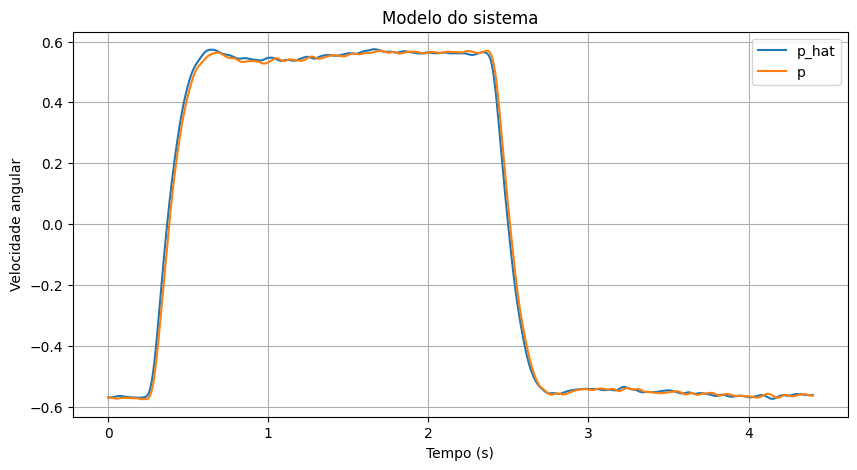

In [24]:
# Plotar os resultados
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(t, p[:, 0], label='p_hat', color='tab:blue')
ax1.plot(tempo, taxa_p, label='p', color='tab:orange')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Velocidade angular')
ax1.set_title('Modelo do sistema')
ax1.legend(loc='upper right')
ax1.grid()
#
plt.show()
